In [1]:
from copy import deepcopy
import datetime as dt
from IPython.display import HTML
import json
import pandas as pd
from arcgis.gis import GIS
import arcgis.network as network
import arcgis.geocoding as geocoding
from arcgis.features import FeatureLayer, FeatureSet, FeatureCollection
import arcgis.features.use_proximity as use_proximity

In [2]:
my_gis = GIS('https://www.arcgis.com', 'srivathskm', 'Hedebyhedge7$', verify_cert=False, set_active=True)

<Item title:"USA Major Cities" type:Feature Layer Collection owner:esri_dm>
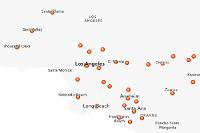

In [3]:
sample_cities = my_gis.content.search('title:"USA Major Cities" type:Feature Service owner:esri*', outside_org=True)[0]
sample_cities

In [5]:
stops_cities = ['San Francisco', 'San Jose', 'Los Angeles', 'San Diego',
                'Phoenix', 'El Paso', 
                'Houston', 'New Orleans', 'Orlando', 'Miami']
values = "'" + "', '".join(stops_cities) + "'"

In [6]:
stops_cities_fl = FeatureLayer(sample_cities.url + "/0")
type(stops_cities_fl)

arcgis.features.layer.FeatureLayer

In [14]:
stops_cities_fset = stops_cities_fl.query(where="ST in ('CA', 'NV', 'TX', 'AZ', 'LA', 'FL')  AND NAME IN ({0})".format(values), as_df=False)
stops_cities_fset

<FeatureSet> 10 features

In [11]:
start_cities_fset = stops_cities_fl.query(where="ST='FL' AND NAME = 'Miami'", as_df=True)
start_cities_fset

,FID,NAME,CLASS,ST,STFIPS,PLACEFIPS,CAPITAL,POP_CLASS,POPULATION,POP2010,...,MARHH_NO_C,MHH_CHILD,FHH_CHILD,FAMILIES,AVE_FAM_SZ,HSE_UNITS,VACANT,OWNER_OCC,RENTER_OCC,SHAPE
0,1724,Miami,city,FL,12,1245000,,8,449517,399457,...,28613,5277,16530,90032,3.15,183994,25677,51186,107131,"{""x"": -8930153.356750246, ""y"": 2969492.4924157..."


In [16]:
def re_order_stop_cities(fset=stops_cities_fset, start_city = "Miami", end_city = "San Francisco"):
    
    stops_cities_flist = []
    last_city = None

    for ea in fset:
        if ea.attributes['NAME'] == start_city:
            stops_cities_flist.insert(0, ea)
        elif ea.attributes['NAME'] == end_city:
            last_city = ea
        else:
            stops_cities_flist.append(ea)
    stops_cities_flist.append(last_city)
 
    return FeatureSet(stops_cities_flist)

In [17]:
re_ordered_stops_cities_fset = re_order_stop_cities()
re_ordered_stops_cities_fset

<FeatureSet> 10 features

In [19]:
re_ordered_stops_cities_fset.spatial_reference = stops_cities_fset.spatial_reference

In [20]:
stops_cities_fset.spatial_reference

{'wkid': 102100, 'latestWkid': 3857}

In [21]:
%%time

start_time = int(dt.datetime.now().timestamp() * 1000)

result = network.analysis.find_routes(re_ordered_stops_cities_fset, time_of_day=start_time, 
                                      time_zone_for_time_of_day="UTC",
                                      preserve_terminal_stops="Preserve None",
                                      reorder_stops_to_find_optimal_routes=True,
                                      save_output_na_layer=True)

WARNING 030194: Data values longer than 500 characters for field [Stops:Name] are truncated.
Network elements with avoid-restrictions are traversed in the output (restriction attribute names: "Through Traffic Prohibited").


CPU times: user 560 ms, sys: 39.7 ms, total: 600 ms
Wall time: 53.4 s


In [25]:
result

ToolOutput(solve_succeeded=True, output_routes=<FeatureSet> 1 features, output_route_edges=<FeatureSet> 0 features, output_directions=<FeatureSet> 259 features, output_stops=<FeatureSet> 10 features, output_network_analysis_layer={"url": "https://logistics.arcgis.com/arcgis/rest/directories/arcgisjobs/world/route_gpserver/jd0026ca7f6a149a0bb8199d5aad1e5b2/scratch/_ags_gpna9fc819b8f0f94387a82d2799da264b94.lyr"}, output_route_data=None, output_result_file=None)

In [27]:
result.output_routes.sdf

,ObjectID,Name,StopCount,StartTime,EndTime,StartTimeUTC,EndTimeUTC,Total_Miles,Total_Kilometers,Total_Minutes,TotalWait_Minutes,TotalViolation_Minutes,FirstStopOID,LastStopOID,Shape_Length,SHAPE
0,1,Miami - San Francisco,10,2020-08-14 23:28:30.384000063,2020-08-16 21:30:04.572999954,2020-08-15 03:28:30.384000063,2020-08-17 04:30:04.572999954,3273.987097,5268.982028,2941.56982,None,None,1724,554,52.942969,"{""paths"": [[[-80.22093452099995, 25.7609192570..."


In [45]:
result.output_directions.sdf

,ObjectID,RouteName,ArriveTime,Type,SubItemType,Text,ElapsedTime,DriveDistance,Shape_Length,SHAPE
0,1,Miami - San Francisco,2020-08-14 23:28:30.384000063,18,1,Start at Miami,0.000000,0.000000,0.000000,None
1,2,Miami - San Francisco,2020-08-14 23:28:30.384000063,2,1,Go east on SW 13th St toward SW 16th Ave,1.283736,0.417399,0.006682,"{""paths"": [[[-80.22093452099995, 25.7609192570..."
2,3,Miami - San Francisco,2020-08-14 23:29:47.407999992,5,1,Turn left on SW 12th Ave (SR-933),3.596946,1.612999,0.023428,"{""paths"": [[[-80.21425999999997, 25.7608600000..."
3,4,Miami - San Francisco,2020-08-14 23:33:23.223999977,21,1,Take the ramp on the right and go on SR-836-TO...,0.705460,0.504081,0.007823,"{""paths"": [[[-80.21453999999994, 25.7842600000..."
4,5,Miami - San Francisco,2020-08-14 23:34:05.552000046,22,1,Take the ramp on the left and go on I-95 N tow...,9.392762,8.960833,0.130628,"{""paths"": [[[-80.20830999999998, 25.7883400000..."
...,...,...,...,...,...,...,...,...,...,...
254,255,Miami - San Francisco,2020-08-16 21:29:02.849999905,2,1,Continue forward on Masonic Ave,0.196061,0.040609,0.000741,"{""paths"": [[[-122.44272999999998, 37.765320000..."
255,256,Miami - San Francisco,2020-08-16 21:29:14.614000082,8,1,Make a sharp right on Upper Ter,0.255134,0.059725,0.000999,"{""paths"": [[[-122.44346999999999, 37.765360000..."
256,257,Miami - San Francisco,2020-08-16 21:29:29.921999931,3,1,Bear left,0.577511,0.067130,0.001101,"{""paths"": [[[-122.44264999999996, 37.765930000..."
257,258,Miami - San Francisco,2020-08-16 21:29:29.921999931,0,3,Restriction: Through Traffic Prohibited,0.000000,0.000000,0.000000,None


In [29]:
result.output_stops.sdf

,ObjectID,Name,RouteName,Sequence,TimeWindowStart,TimeWindowEnd,ArriveCurbApproach,DepartCurbApproach,ArriveTime,DepartTime,...,Cumul_Minutes,Wait_Minutes,CumulWait_Minutes,Violation_Minutes,CumulViolation_Minutes,ORIG_FID,Bearing,BearingTol,NavLatency,SHAPE
0,1,Los Angeles,None,8,NaT,NaT,1.0,1.0,2020-08-16 15:10:08.681999922,2020-08-16 15:10:08.681999922,...,2561.638299,None,None,None,None,415,None,None,None,"{""x"": -118.27058226399998, ""y"": 34.05278960900..."
1,2,San Diego,None,7,NaT,NaT,1.0,1.0,2020-08-16 12:47:11.520999907,2020-08-16 12:47:11.520999907,...,2418.685622,None,None,None,None,550,None,None,None,"{""x"": -117.14556412399997, ""y"": 32.72032870400..."
2,3,San Francisco,None,10,NaT,NaT,2.0,NaN,2020-08-16 21:30:04.572999954,2020-08-16 21:30:04.572999954,...,2941.569820,None,None,None,None,554,None,None,None,"{""x"": -122.44244956899996, ""y"": 37.76692355400..."
3,4,San Jose,None,9,NaT,NaT,2.0,2.0,2020-08-16 20:32:51.190000057,2020-08-16 20:32:51.190000057,...,2884.346767,None,None,None,None,558,None,None,None,"{""x"": -121.88641492299996, ""y"": 37.33941397400..."
4,5,Phoenix,None,6,NaT,NaT,1.0,2.0,2020-08-16 07:26:59.161999941,2020-08-16 07:26:59.161999941,...,2098.479632,None,None,None,None,910,None,None,None,"{""x"": -112.07386809299999, ""y"": 33.44611430800..."
5,6,New Orleans,None,3,NaT,NaT,1.0,1.0,2020-08-15 11:28:40.236000061,2020-08-15 11:28:40.236000061,...,780.164203,None,None,None,None,1278,None,None,None,"{""x"": -90.07521241799998, ""y"": 29.953202926000..."
6,7,Miami,None,1,NaT,NaT,NaN,1.0,2020-08-14 23:28:30.384000063,2020-08-14 23:28:30.384000063,...,0.000000,None,None,None,None,1724,None,None,None,"{""x"": -80.22093249899996, ""y"": 25.760860335000..."
7,8,Orlando,None,2,NaT,NaT,2.0,2.0,2020-08-15 03:09:56.065999985,2020-08-15 03:09:56.065999985,...,221.428035,None,None,None,None,1757,None,None,None,"{""x"": -81.37228760599999, ""y"": 28.537235995000..."
8,9,El Paso,None,5,NaT,NaT,1.0,1.0,2020-08-16 02:20:43.329999924,2020-08-16 02:20:43.329999924,...,1732.215768,None,None,None,None,3605,None,None,None,"{""x"": -106.48717612899998, ""y"": 31.75760321300..."
9,10,Houston,None,4,NaT,NaT,2.0,2.0,2020-08-15 16:51:36.608000040,2020-08-15 16:51:36.608000040,...,1103.103728,None,None,None,None,3641,None,None,None,"{""x"": -95.36750698599997, ""y"": 29.758761427000..."


In [31]:
result.output_route_edges.sdf

""


In [32]:
result.output_stops.sdf

,ObjectID,Name,RouteName,Sequence,TimeWindowStart,TimeWindowEnd,ArriveCurbApproach,DepartCurbApproach,ArriveTime,DepartTime,...,Cumul_Minutes,Wait_Minutes,CumulWait_Minutes,Violation_Minutes,CumulViolation_Minutes,ORIG_FID,Bearing,BearingTol,NavLatency,SHAPE
0,1,Los Angeles,None,8,NaT,NaT,1.0,1.0,2020-08-16 15:10:08.681999922,2020-08-16 15:10:08.681999922,...,2561.638299,None,None,None,None,415,None,None,None,"{""x"": -118.27058226399998, ""y"": 34.05278960900..."
1,2,San Diego,None,7,NaT,NaT,1.0,1.0,2020-08-16 12:47:11.520999907,2020-08-16 12:47:11.520999907,...,2418.685622,None,None,None,None,550,None,None,None,"{""x"": -117.14556412399997, ""y"": 32.72032870400..."
2,3,San Francisco,None,10,NaT,NaT,2.0,NaN,2020-08-16 21:30:04.572999954,2020-08-16 21:30:04.572999954,...,2941.569820,None,None,None,None,554,None,None,None,"{""x"": -122.44244956899996, ""y"": 37.76692355400..."
3,4,San Jose,None,9,NaT,NaT,2.0,2.0,2020-08-16 20:32:51.190000057,2020-08-16 20:32:51.190000057,...,2884.346767,None,None,None,None,558,None,None,None,"{""x"": -121.88641492299996, ""y"": 37.33941397400..."
4,5,Phoenix,None,6,NaT,NaT,1.0,2.0,2020-08-16 07:26:59.161999941,2020-08-16 07:26:59.161999941,...,2098.479632,None,None,None,None,910,None,None,None,"{""x"": -112.07386809299999, ""y"": 33.44611430800..."
5,6,New Orleans,None,3,NaT,NaT,1.0,1.0,2020-08-15 11:28:40.236000061,2020-08-15 11:28:40.236000061,...,780.164203,None,None,None,None,1278,None,None,None,"{""x"": -90.07521241799998, ""y"": 29.953202926000..."
6,7,Miami,None,1,NaT,NaT,NaN,1.0,2020-08-14 23:28:30.384000063,2020-08-14 23:28:30.384000063,...,0.000000,None,None,None,None,1724,None,None,None,"{""x"": -80.22093249899996, ""y"": 25.760860335000..."
7,8,Orlando,None,2,NaT,NaT,2.0,2.0,2020-08-15 03:09:56.065999985,2020-08-15 03:09:56.065999985,...,221.428035,None,None,None,None,1757,None,None,None,"{""x"": -81.37228760599999, ""y"": 28.537235995000..."
8,9,El Paso,None,5,NaT,NaT,1.0,1.0,2020-08-16 02:20:43.329999924,2020-08-16 02:20:43.329999924,...,1732.215768,None,None,None,None,3605,None,None,None,"{""x"": -106.48717612899998, ""y"": 31.75760321300..."
9,10,Houston,None,4,NaT,NaT,2.0,2.0,2020-08-15 16:51:36.608000040,2020-08-15 16:51:36.608000040,...,1103.103728,None,None,None,None,3641,None,None,None,"{""x"": -95.36750698599997, ""y"": 29.758761427000..."
